<a href="https://colab.research.google.com/github/cannonbunny/stock-sentiment-analysis/blob/master/GRU_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import requirements

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random

import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout, Flatten
from keras.optimizers import SGD

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Combine data as features

In [3]:
dataset_NLP = pd.read_csv("/content/drive/My Drive/FISA_pred.csv", parse_dates=[1])
dataset_NLP = dataset_NLP[['date','0','1','2']]
dataset_general = pd.read_csv("/content/drive/My Drive/GSPC_fin.csv", parse_dates =[0]).dropna()
dataset_general = dataset_general.join(dataset_NLP.set_index('date'), on='Date')

In [4]:
for i in np.array([7,14,28]):
    expMA = pd.Series.ewm(dataset_general['y_Close'], span=i).mean().to_frame()
    expMA = expMA.rename(columns={'y_Close': 'ema{}'.format(i)})
    dataset_general = dataset_general.join(expMA)

MACD = pd.Series(dataset_general['y_Close'].ewm(span=12, min_periods=12).mean() - dataset_general['y_Close'].ewm(span=26, min_periods=12).mean(), name='MACD')
dataset_general = dataset_general.join(MACD)

SO = pd.Series((dataset_general['y_Close'] - dataset_general['y_Low'].rolling(window=5, min_periods=5).max()) / (dataset_general['y_High'].rolling(window=5, min_periods=5).min() - dataset_general['y_Low'].rolling(window=5, min_periods=5).min()), name='SO')
dataset_general = dataset_general.join(SO)

In [5]:
dummy_value = 0.1
dataset_general.fillna(value=dummy_value, inplace=True)
dataset_general.columns

Index(['Date', 'y_Open', 'y_High', 'y_Low', 'y_Close', 'y_Vix', 'y_Dow',
       'y_Tech', 'Close', 'Volume', '0', '1', '2', 'ema7', 'ema14', 'ema28',
       'MACD', 'SO'],
      dtype='object')

# Training and tesing using GRU model

In [ ]:
def get_gru_model(input_shape):
  model = Sequential()
  model.add(GRU(units=512, return_sequences=True, input_shape=input_shape, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(GRU(units=256, return_sequences=True, input_shape=input_shape, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(GRU(units=256, return_sequences=True, input_shape=input_shape, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(GRU(units=64, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))
  model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')
  return model

def train_and_predict(data, feature_list):
  print("Training data for columns of: ", feature_list)
  train_set_x = data.iloc[:710][feature_list].values
  predict_set = data.iloc[680:][feature_list].values

  train_set_y = data.iloc[:710]['y_Close'].values
  train_set_y = train_set_y.reshape((len(train_set_y), 1))

  test_set_y = data.iloc[710:890]['Close'].values
  test_set_y = test_set_y.reshape((len(test_set_y), 1))

  sc_x = MinMaxScaler(feature_range = (0,1))
  train_scaler_x = sc_x.fit_transform(train_set_x)

  sc_y = MinMaxScaler(feature_range = (0,1))
  train_scaler_y = sc_y.fit_transform(train_set_y)

  num_features = len(feature_list)

  train_range_x = []
  train_range_y = []
  for i in range(30,710):
    train_range_x.append(train_scaler_x[i-30:i, 0:])
    train_range_y.append(train_scaler_y[i,0])
  train_range_x, train_range_y = np.array(train_range_x), np.array(train_range_y)
  train_range_x = np.reshape(train_range_x, (train_range_x.shape[0], train_range_x.shape[1], num_features))
  train_range_y = np.reshape(train_range_y, (train_range_y.shape[0], 1))

  model = get_gru_model(input_shape=(train_range_x.shape[1], num_features))
  history = model.fit(train_range_x, train_range_y, epochs=30, batch_size=21)
  dummy_fit = sc_y.fit_transform(test_set_y)
  predict_inputs = sc_x.fit_transform(predict_set)
  predict_x = []
  for i in range(30,210):
      predict_x.append(predict_inputs[i-30:i,0:])

  predict_x = np.array(predict_x)
  predict_x = np.reshape(predict_x, (predict_x.shape[0],predict_x.shape[1],num_features))
  
  predicted_price = model.predict(predict_x)
  print(model.evaluate(predict_x, test_set_y))
  predicted_price = sc_y.inverse_transform(predicted_price)
  return predicted_price

In [ ]:
# usage example
# pred_vix = train_and_predict(dataset_general, ["y_Vix"])
# pred_nlp = train_and_predict(dataset_general, ["0", "1", "2"])
pred_vix_nlp = train_and_predict(dataset_general, ["y_Vix", "0", "1", "2"])
pred_technical_indicator = train_and_predict(dataset_general, ["ema7", "ema14", "ema28", "MACD","SO"])
pred_combine = train_and_predict(dataset_general, ['y_Open','y_Low','y_High','y_Close','y_Vix', 'y_Dow', '0', '1', '2', 
                                                   'ema7', 'ema14','ema28', 'MACD', 'SO'])

Training data for columns of:  ['y_Vix', '0', '1', '2']
Epoch 1/30
33/33 [==============================] - 12s 366ms/step - loss: 0.0928
Epoch 2/30
33/33 [==============================] - 12s 369ms/step - loss: 0.0386
Epoch 3/30
33/33 [==============================] - 12s 362ms/step - loss: 0.0306
Epoch 4/30
33/33 [==============================] - 12s 356ms/step - loss: 0.0282
Epoch 5/30
33/33 [==============================] - 12s 365ms/step - loss: 0.0245
Epoch 6/30
33/33 [==============================] - 12s 362ms/step - loss: 0.0226
Epoch 7/30
33/33 [==============================] - 12s 359ms/step - loss: 0.0255
Epoch 8/30
33/33 [==============================] - 12s 361ms/step - loss: 0.0235
Epoch 9/30
33/33 [==============================] - 12s 356ms/step - loss: 0.0243
Epoch 10/30
33/33 [==============================] - 12s 358ms/step - loss: 0.0226
Epoch 11/30
33/33 [==============================] - 12s 359ms/step - loss: 0.0227
Epoch 12/30
33/33 [=====================

In [ ]:
testset_y = dataset_general.iloc[710:890]['Close'].values
testset_y = testset_y.reshape((len(testset_y), 1))

# Display results

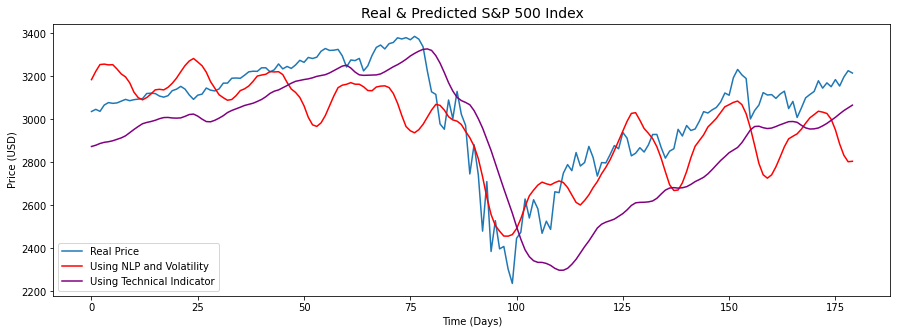

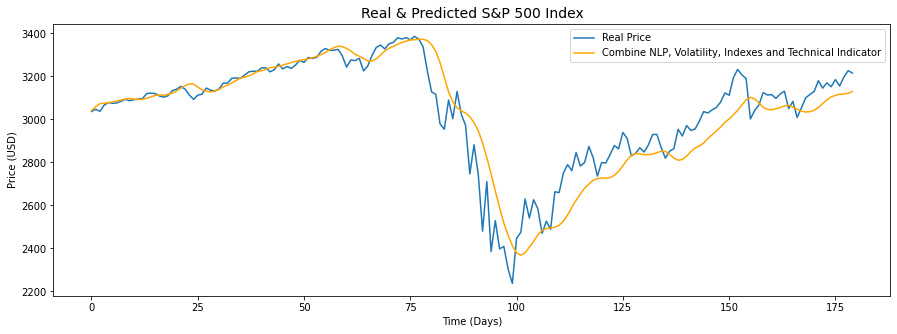

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Real & Predicted S&P 500 Index", fontsize=14)
plt.xlabel("Time (Days)")
plt.ylabel("Price (USD)")
plt.plot(testset_y, label = 'Real Price')
plt.plot(pred_vix_nlp, color = 'red', label = 'Using NLP and Volatility')
plt.plot(pred_technical_indicator, color = 'purple', label = 'Using Technical Indicator')
plt.legend()
# plt.savefig("/content/drive/My Drive/abc.jpg")
plt.show()

plt.figure(figsize=(15,5))
plt.title("Real & Predicted S&P 500 Index", fontsize=14)
plt.xlabel("Time (Days)")
plt.ylabel("Price (USD)")
plt.plot(testset_y, label = 'Real Price')
plt.plot(pred_combine, color = 'orange', label = 'Combine NLP, Volatility, Indexes and Technical Indicator')
plt.legend()
# plt.savefig("/content/drive/My Drive/xyz.jpg")
plt.show()


In [ ]:
# produce root mean square error
from sklearn.metrics import mean_squared_error
print("rmse pred_technical_indicator", mean_squared_error(testset_y, pred_technical_indicator)** 0.5)
print("rmse pred_vix_nlp", mean_squared_error(testset_y, pred_vix_nlp) ** 0.5)
print("rmse pred_combine", mean_squared_error(testset_y, pred_combine)** 0.5)

rmse pred_technical_indicator 209.75033890729426
rmse pred_vix_nlp 172.03565932209332
rmse pred_combine 100.94838031270949
